# Plot Figures 7 (maps), 8 (boxplots), 9 (hour), 10 (GPS), 

Analyzing clusters through time and by features

For Sawi et al., 2021

## Todo::

* Combine figure 11, features


In [1]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from obspy import read
from matplotlib import cm
import matplotlib.gridspec as gridspec
import os
import datetime as dtt
import matplotlib.patches
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from  sklearn.preprocessing import StandardScaler
import sys
from matplotlib.patches import Rectangle
import sklearn.metrics
from scipy import spatial
import matplotlib.image as mpimg
import obspy
from scipy.signal import butter, lfilter
import librosa
from scipy.io import loadmat
from sklearn.decomposition import PCA
import scipy.io as spio
from sklearn.metrics import silhouette_samples
import seaborn as sns
import scipy as sp
import scipy.io as spio
import scipy.signal
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from obspy.signal.cross_correlation import correlate, xcorr_max


sys.path.append('.')
sys.path.append('../src/visualization/')

import paths
from sklearn.cluster import KMeans
# import figureFunctions

In [2]:


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat 
from functions2 import catMergeFromH5, swapLabels, calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2

## Define helper functions (move later)

## Set paths

In [3]:
#%% load project variables: names and paths
# key = sys.argv[1]

key = "BB_Gorner_Event_Final_v11_J8"
keyN = "BB_Gorner_Cont_Final_v10_J8"


filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station         = pN['station']
channel         = pN['channel']


path_top        = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN        = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 



# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN


pathFig = '../reports/figures/'
pathAuxData = '../data/processed/Garcia/'

## Load auxiliary data

In [4]:
## Load auxiliary catalog

gps_station_list = ['24','34','36','37']
gps_df_list = []

for gst in gps_station_list:
    
    
    gps_df = pd.read_csv(f'{pathAuxData}gps_roll_Slopecorrected_{gst}.csv',index_col=0)
    gps_df['datetime'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df['datetime_index'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df = gps_df.set_index('datetime_index')
    
    
    gps_df_list.append(gps_df)


lake_df = pd.read_csv(f'{pathAuxData}lake_df.csv',index_col=0)
lake_df['datetime'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df['datetime_index'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df = lake_df.set_index('datetime_index')


meteor_df = pd.read_csv(f'{pathAuxData}meteor_df.csv',index_col=0)
meteor_df['datetime'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df['datetime_index'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df = meteor_df.set_index('datetime_index')

rain_df = meteor_df.rain


In [5]:
len(gps_df)


920

## Define some important times in study period

In [6]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load cluster catalogs

In [7]:
Kopt = 3
KoptN = 4

cat00 = pd.read_csv('../data/interim/icequakes_k{Kopt}.csv')

cat00N = pd.read_csv('../data/interim/noise_k{KoptN}.csv')



cat00['event_ID'] = [str(i) for i in cat00.event_ID]
## convert to datetime, set as index
cat00['datetime'] = [pd.to_datetime(i) for i in cat00.datetime]
cat00['datetime_index']= [pd.to_datetime(i) for i in cat00.datetime]
cat00 = cat00.set_index('datetime_index')


## convert to datetime, set as index
cat00N['event_ID'] = [str(i) for i in cat00N.event_ID]

cat00N['datetime'] = [pd.to_datetime(i) for i in cat00N.datetime]
cat00N['datetime_index']= [pd.to_datetime(i) for i in cat00N.datetime]
cat00N = cat00N.set_index('datetime_index')

In [8]:
cat00N.Cluster

datetime_index
2007-06-14 01:06:58    1
2007-06-14 03:15:42    1
2007-06-14 03:27:42    1
2007-06-14 03:49:12    1
2007-06-14 05:44:43    1
                      ..
2007-07-21 23:46:28    2
2007-07-21 23:58:13    2
2007-07-22 00:08:58    2
2007-07-22 00:20:43    2
2007-07-22 00:34:28    2
Name: Cluster, Length: 1521, dtype: int64

## Load station data

In [9]:
##station data 
stn = pd.read_csv("../data/raw/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        
     

## Get experiment parameters from H5 file

In [10]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
    fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Load specufex output

In [11]:

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - IQIQIQIQIQIQIQIQIQIQ
 
#########       #########       #########       #########       #########       #########       #########       #########       Wmat = loadmat(pathW)

Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]



order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - NOISENOISENOINSENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]


order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC


todo: fix ::


##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat0.event_ID.resample('D', label='left', closed='right').count()

In [12]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
## start of

#all times in UTC
hour_of_approx_max_temp = 14
# hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]


## ts 2021/08/07 : change line to start of day
dayStart = hourMaxTemp = [dtt.datetime(2007, 6, 14) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [13]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend,     ## actual study bound
              'supraDraint':supraDraint,
              'subDraint':subDraint,
              'drainEndt':drainEndt}            


## Specs for figures JGR

In [14]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

# Figure 7 - Map of Icequakes


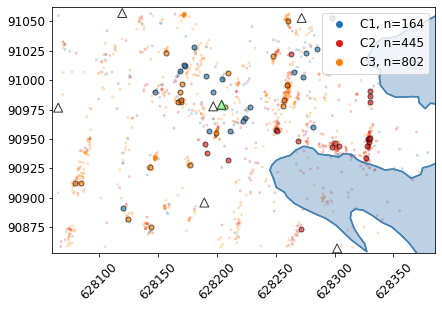

In [15]:
topF = 20
catRep = getTopFCat(cat00,topF)


##v3 separate map for each cluster
##settings for yellow bars
plotMap = 0
size1 = 1000
a1 = .7

k=3
plt.rcParams.update({'font.size': 12})


# if 'Event' in key:
fig,axes = plt.subplots(figsize = (width2,height1))#,sharex=True,constrained_layout=True)


gs = gridspec.GridSpec(1,1)

# gs.update(wspace=0.02, hspace=0.07)

ax = plt.subplot(gs[0])

ax.set_aspect('equal')
ax.tick_params(axis='x',labelrotation=45)


# cat00k = cat00[cat00.Cluster==k]





figureFunctions2.plotMap(cat00,
        ax=ax,
        colorBy='cluster',
        size=3,
        lw=1,
        alpha=.3,
        edgecolor='cluster',
        **plt_kwargs); #'oneCluster''cluster';'all';'datetime'


figureFunctions2.plotMap(catRep,
        ax=ax,
        colorBy='cluster',
        size=25,
        marker='o',
        lw=1,
        alpha=.6,
        edgecolor='None',
        **plt_kwargs); #'oneCluster''cluster';'all';'datetime'




###% Stations

figureFunctions2.plotStations(stn,station,ax=ax)   



#%% Legend


from matplotlib.lines import Line2D

ms2 = 6

n_list = [len(cat00[cat00.Cluster==k]) for k in range(1,Kopt+1)]

legend_elements = [Line2D([0], [0], marker='o', linestyle='None', color=colors[0], label=f'C1, n={n_list[0]}',markersize=ms2),
                    Line2D([0], [0], marker='o', linestyle='None', color=colors[1], label=f'C2, n={n_list[1]}',markersize=ms2),
                    Line2D([0], [0], marker='o', linestyle='None', color=colors[2], label=f'C3, n={n_list[2]}',markersize=ms2)]

# Create the figure

ax.legend(handles=legend_elements)#, loc='center')



#%% limits 


buff=5
ax.set_xlim(cat00.X_m.min()-buff,cat00.X_m.max()+buff)
ax.set_ylim(cat00.Y_m.min()-buff,cat00.Y_m.max()+buff)


plt.savefig(pathFig + f'Figure_7.png',bbox_inches='tight')



# Figure 8

## Get Features for Rep Events


In [16]:
catRepN = getTopFCat(cat00N,topF)


gF = 1
if gF:
    
    print('getting features for events...')
    df = getFeatures(catRep,filetype,fmin,fmax,fs,path_WF,nfft,dataH5_path,station,channel)
    
    print('getting features for noise...')    
    dfN = getFeatures(catRepN,filetypeN,fminN,fmaxN,fsN,path_WFN,nfftN,dataH5_pathN,station,channel)
    print('done!')
    
    # get location features


    print('getting location features for events...')    
    df_loc = getLocationFeatures(catRep,stn,station)

getting features for events...


/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2001
  n_fft, y.shape[-1]


getting features for noise...
done!
getting location features for events...


# Figure 8 - Boxplots 

## plot feature boxplots


/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


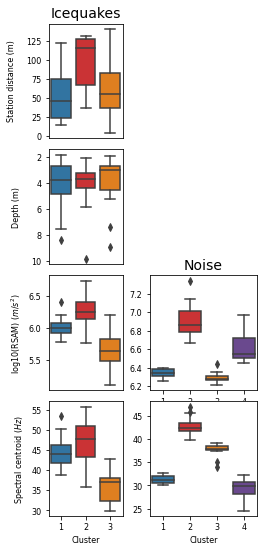

In [24]:





plt.rcParams.update({'font.size': 8})

fig,axes = plt.subplots(figsize = (width1,height2))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(4,7)
gs.update(wspace=4, hspace=0.1)


FS = 13 #'Cluster' x label

tfont = 14
tpad = 6
title = 'Icequakes'
titleN = 'Noise'

textYN = 8
textY = 7.8



# ### ### ### ### ### ### ### ### ### ### ### ### 
# ### ### ### ### ### ### ### ### ### ### ### ### 
# ####### LOCATION LOCATION LOCATION
# ### ### ### ### ### ### ### ### ### ### ### ### 
# ### ### ### ### ### ### ### ### ### ### ### ### 

## plot 3D dist boxplot
ax = plt.subplot(gs[0,0:3])
ax.set_title(title,fontsize=tfont,pad=tpad)

figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'DistXYZ_m',ax=ax,**plt_kwargs)
ax.set_ylabel('Station distance (m)',labelpad=10)
ax.set_xlabel('')
ax.set_xticks([])
ax.set_xticklabels('')



## plot full Depth boxplot
ax = plt.subplot(gs[1,0:3])
figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'Depth_m',ax=ax,**plt_kwargs)
ax.invert_yaxis()

ax.set_ylabel('')
ax.set_xticks([])
ax.set_xticklabels('')
ax.set_xlabel('')

ax.set_ylabel('Depth (m)',labelpad=10)


### ### ### ### ### ### ### ### ### ### ### ### 
### ### ### ### ### ### ### ### ### ### ### ### 
## plot boxplot for RSAM
ax = plt.subplot(gs[2,0:3])

figureFunctions2.plotFeatureBoxPlot(df,Kopt,'log10RSAM',ax=ax,**plt_kwargs)
ax.set_ylabel('log10(RSAM) ($m/s^2$)',labelpad=5)
ax.set_xticks([])
ax.set_xticklabels('')
ax.set_xlabel('')
# ax.grid('off')



### ### ### ### ### ### ### ### ### ### ### ### 
## plot Boxplot for SC
ax = plt.subplot(gs[3,0:3])
figureFunctions2.plotFeatureBoxPlot(df,Kopt,'SC',ax=ax,**plt_kwargs)
# ax.set_xlabel('Cluster',labelpad=4,fontsize=FS)
ax.set_ylabel('Spectral centroid ($Hz$)',labelpad=5)
# ax.set_xticks([])
# ax.set_xticklabels('')
# ax.set_xlabel('')
# ax.grid('off')




### ### ### ### ### ### ### ### ### ### ### ### 
### ### ### ### ### ### ### ### ### ### ### ### 
####### NOISENOISENOISE
### ### ### ### ### ### ### ### ### ### ### ### 
### ### ### ### ### ### ### ### ### ### ### ### 


### ### ### ### ### ### ### ### ### ### ### ### 
### ### ### ### ### ### ### ### ### ### ### ### 
## plot boxplot for RSAM NOISE
ax = plt.subplot(gs[2,3:])
ax.set_title(titleN,fontsize=tfont,pad=tpad)
figureFunctions2.plotFeatureBoxPlot(dfN,KoptN,'log10RSAM',ax=ax,**plt_kwargs)
# ax.set_ylabel('log10(RSAM)',labelpad=12)
ax.set_ylabel('')




### ### ### ### ### ### ### ### ### ### ### ### 
## plot Boxplot for SC NOISE
ax = plt.subplot(gs[3,3:])
figureFunctions2.plotFeatureBoxPlot(dfN,KoptN,'SC',ax=ax,**plt_kwargs)
# ax.set_ylabel('Spectral centroid (Hz)',labelpad=4)
ax.set_ylabel('')








plt.tight_layout()
plt.savefig(pathFig + f'Figure_8.png',bbox_inches='tight')

# Figure 9 - Hourly clusters

../src/visualization/functions2.py:320: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  temp_H = meteor_df1.temp.resample('H',loffset='30T').mean().ffill()
../src/visualization/functions2.py:321: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  temp_D = meteor_df1.temp.resample('D',loffset='12H').mean().ffill()


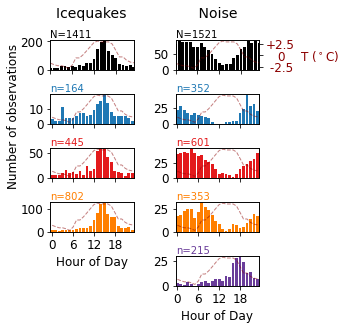

In [18]:
plt.rcParams.update({'font.size': 12})
title = 'Icequakes'
titleN = 'Noise'
dailyTempDiff = getDailyTempDiff(meteor_df,**plt_kwargs)


tfont = 14
tpad = 16

fig,axes = plt.subplots(figsize = (width1,height1))#,sharex=True)#,constrained_layout=True)

plt.suptitle('Icequakes                Noise  ',fontsize=tfont)  

gs = gridspec.GridSpec(KoptN+1, 2)

# gs.update(left=0.05, right=0.35, wspace=.3, hspace=1)
gs.update(wspace=.5, hspace=.8)


### ICEQUAKE PROPORTION HOURLY
ax = plt.subplot(gs[0,0])

figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=20,label='none',colorBy='all',k=0,**plt_kwargs)
ax.set_title(f'N={len(cat00)}', loc='left',fontsize=10,pad=1,color='k')
ax.set_ylabel('')
ax.set_xlim(0,23)
ax.set_xticklabels([]) 
ax.set_xlabel('')

### ICEQUAKES BY CLUSTER HOURLY

for k in range(1,Kopt+1):
    
    i = k
    
    ax = plt.subplot(gs[i,0])
    ax.set_title(f'n={len(cat00[cat00.Cluster==k])}', loc='left',fontsize=10,pad=1,color=colors[k-1])
    
#     figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,colorBy='cluster',k=k,**plt_kwargs)
    
    if k == 0:
        figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,label='right',colorBy='cluster',k=k,**plt_kwargs)
#         ax.set_title(title,fontsize=tfont,pad=tpad)  
    else:
        figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
        ax.set_ylabel('')
        
    
    if k != Kopt:        
        ax.set_xlabel('')
        ax.set_xticklabels([])  
    if k == 1:
        ax.set_ylabel('Number of observations    ',labelpad=8)
    
#     ax.set_yticklabels([])  

        
        
# ### NOISE PROPORTION HOURLY
axN = plt.subplot(gs[0,1])

figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=axN,labelpad=20,label='right',colorBy='all',k=0,**plt_kwargs)

axN.set_title(f'N={len(cat00N)}', loc='left',fontsize=10,pad=1,color='k')
axN.set_ylabel('')
axN.set_xlim(0,23)
axN.set_xticklabels([]) 
axN.set_xlabel('')

### NOISE BY CLUSTER HOURLY
for k in range(1,KoptN+1):
    
    i = k
    
    axN = plt.subplot(gs[i,1])

    axN.set_title(f'n={len(cat00N[cat00N.Cluster==k])}', loc='left', fontsize=10,pad=1,color=colors[k-1])
    if k == 0:
        figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=axN,labelpad=20,label='none',colorBy='cluster',k=k,**plt_kwargs)

    if k != 1:
        figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=axN,labelpad=10,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
        axN.set_ylabel('')
#         ax.set_yticks([])   
    else:
        figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=axN,labelpad=8,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
    if k != KoptN:
        axN.set_xticklabels([]) 

        axN.set_xlabel('')

plt.savefig(pathFig + f'Figure_9.png',bbox_inches='tight')


# Figure 10 -  Clusters and GPS displacement over season

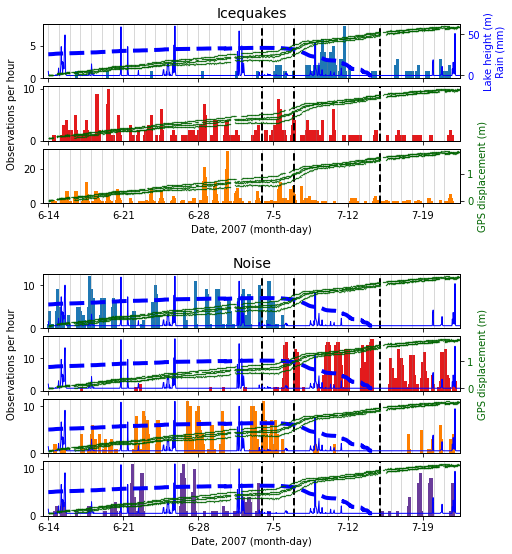

In [26]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'font.size': 10})
fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)



gs = gridspec.GridSpec(KoptN+Kopt+1,1)
gs.update(wspace=.6, hspace=.15)

tpad = 6


gpsstations = [24,34,36,37]

timecode = '3H'
datatype = ''


title = 'Icequakes'
textY = 16  

titleN = 'Noise'
textYN = 17.5

for k in range(1,Kopt+1):
    
    ax=plt.subplot(gs[k-1,0])
#     ax.set_ylim(0,20)
#     ax.set_ylim(ymin=0)
    figureFunctions2.plotBarCluster(cat00,k=k,barWidth=.3,timeBin='H',ax=ax,**plt_kwargs)

    
    if k == 1:

#         figureFunctions2.plotTemp(meteor_df.temp,ax=ax,**plt_kwargs)  
#         figureFunctions2.plotTemp(meteor_df.temp,ax=ax,**plt_kwargs)   
#         figureFunctions2.plotTemp(meteor_df.temp,ax=ax,**plt_kwargs)   
        ax.set_title(title,fontsize=tfont,pad=tpad)
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='right',ax=ax,**plt_kwargs)  

        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',ax=ax,**plt_kwargs)
    
    elif k==2:    
        ax.set_ylabel('Observations per hour',labelpad=6)    
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',ax=ax,**plt_kwargs)
            
            
    elif k==3:
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='right',ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',ax=ax,**plt_kwargs)
    
    else:
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='none',ax=ax,**plt_kwargs)
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',ax=ax,**plt_kwargs)
            
        ## lol 3 for alpha
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)  
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)   
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)               
        
    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,c='k',linestyle='--',linewidth=2, alpha=1)   
    ax.axvline(x=drainEndt,color='k',ls='--',linewidth=2)


    if k == Kopt:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')

        
        
ax=plt.subplot(gs[Kopt,0])
ax.axis('off')



for k in range(1,KoptN+1):
    
    ax=plt.subplot(gs[k-1+Kopt+1,0])
#     ax.set_ylim(ymin=0)

    figureFunctions2.plotBarCluster(cat00N,k=k,barWidth=.3,ax=ax,**plt_kwargs)
    figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel=None,ax=ax,**plt_kwargs)
    ## lol 3 for alpha
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)  
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)   
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)   
    
    
    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,c='k',linestyle='--',linewidth=2, alpha=1)   
    ax.axvline(x=drainEndt,color='k',ls='--',linewidth=2)
    
    
    if k == 1:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        ax.set_title(titleN,fontsize=tfont,pad=tpad)
        

   
    if k == 2:

        ax.set_ylabel('Observations per hour',labelpad=6)  
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='right',ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',ax=ax,**plt_kwargs)
    else:
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',ax=ax,**plt_kwargs)

    if k == KoptN:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
plt.savefig(pathFig + f'Figure_10.png',bbox_inches='tight')